# Week 8 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic networks. A word or document network is an unsupervized representation of text akin to a clustering or an embedding, but semantic networks can also be defined using semantic or syntactic information derived from methods we have used earlier in the quarter. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify *them*). Rendering words linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, andsophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity.

Define a function for plotting networks:

In [2]:
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
#from ggplot import *
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

import sys
def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()

from matplotlib.font_manager import FontProperties
ChineseFont1 = FontProperties(fname = "/Library/Fonts/Songti.ttc")




def Filter_keepCompNum(G,filter_="betweenness"):
    G_temp = G.copy()
    
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ =="closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")
        
    
    Compnum = nx.number_connected_components(G)
    sorted_index = sorted(index.items(), key=lambda x:x[1])
    G_last = G_temp.copy()
    for i in range(len(sorted_index)-1):
        
        G_last.remove_nodes_from([n[0] for n in sorted_index[:len(sorted_index)-i]])
        if not nx.number_connected_components(G_last)==Compnum:
            G_last = G_temp.copy()
        flushPrint("Total number of nodes (after iteration %s) in the graph is %s" % (i+1,len(G_last)))  
    
    #remove low weight edges
    G = G_last.copy()
    w_dis = []
    for n1, n2, d in G.edges(data = True):
        w_dis.append(d['weight'])
    w_dis = np.array(w_dis)
    minWeight = np.percentile(w_dis,25)
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] <= minWeight])
    except:
        print("weight might be missing from one or more edges.")
        raise
    print()
    print ("Low weight edges removed. Total edge: %s" % len(G.edges) )
    
    G = G.copy()
    indx = nx.isolates(G)
    G.remove_nodes_from([idx for idx in indx])
    print ("Total number of nodes(after removing isolated nodes) in the graph is %s" % len(G))
    return G




def TSNE_based_network_plot(G_temp2):

    G_adj_matrix = nx.to_numpy_matrix(G_temp2)
    Colnames = list(G_temp2.nodes)
    G_df =pd.DataFrame(G_adj_matrix,columns=Colnames)
    indx_dic = {}
    for i in range(len(G_df)):
        indx_dic[i] = Colnames[i]
    G_df = G_df.rename(index = indx_dic)
    G_df.head(5)

    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(G_df.loc[:,G_df.columns].values)

    df_tsne = G_df.loc[:,G_df.columns].copy()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]

    MaxW = np.max(np.max(df_tsne[:-2]))
    EGDE_TOTAL = df_tsne[:-2].sum()
    fig = plt.figure(figsize=[15,10])
    for item in df_tsne.itertuples():
        x = item[-2]
        y = item[-1]

        plt.plot(x,y,'o',alpha=0.7,color='blue',markersize=np.min([EGDE_TOTAL[item.Index],25]))
        plt.text(x, y,item.Index,fontsize =np.min([EGDE_TOTAL[item.Index],25]),fontproperties=ChineseFont1)


    for i, node1 in enumerate(df_tsne.columns[:-2]):
        for node2 in df_tsne.columns[i:-2]:
            if not node1==node2:
                if df_tsne.loc[node1,node2]>0:
                    weight = df_tsne.loc[node1,node2]

                    newweight = np.array(weight/float(MaxW))
                    #newweight = newweight**2

                    x1 = df_tsne.loc[node1,'x-tsne']
                    y1 = df_tsne.loc[node1,'y-tsne']
                    x2 = df_tsne.loc[node2,'x-tsne']
                    y2 = df_tsne.loc[node2,'y-tsne']
                    plt.plot([x1,x2],[y1,y2],'b-',linewidth = 6*newweight,alpha = newweight)
    plt.show()


For this notebook we will use the following packages:

In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas as pd#For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats

import pickle #if you want to save layouts
import os

%matplotlib inline

In [4]:
import jieba

In [3]:
#plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
#plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [3]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [4]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [5]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [6]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [7]:
g.nodes[1]

{}

In [8]:
g.nodes[1]['type'] = 'NN'

In [9]:
g.nodes[1]

{'type': 'NN'}

In [10]:
g.nodes[2]['name'] = 'dog'

In [11]:
g.nodes[2]

{'name': 'dog'}

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [12]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [13]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize our graph now:

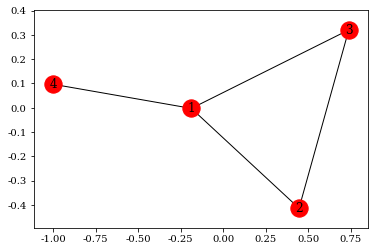

In [14]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here.

First let's load some data, like the Grimmer Senate press releases corpus:

In [43]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now).

In [44]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

Let's begin by looking at words that co-occur in the same sentences:

In [45]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

First, build a graph based on word cooccurences in the first 100 press releases.

In [46]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

Total number of vertices:

In [47]:
len(g.nodes)

4270

Total number of edges:

In [48]:
len(g.edges)

2082420

A part of the adjacency matrix of cleaned word by press releases:

In [49]:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[ 0.,  0.,  0.,  0.,  0.],
        [ 0., 38.,  0.,  6.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  6.,  0., 26.,  2.],
        [ 0.,  0.,  0.,  2.,  0.]])

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [22]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [50]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [51]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [52]:
senVects_incidence.shape

(100, 4270)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [82]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [83]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 4370
Number of edges: 22325
Average degree:  10.2174


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

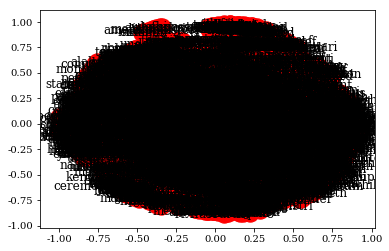

In [28]:
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [84]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [85]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [86]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

In [32]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

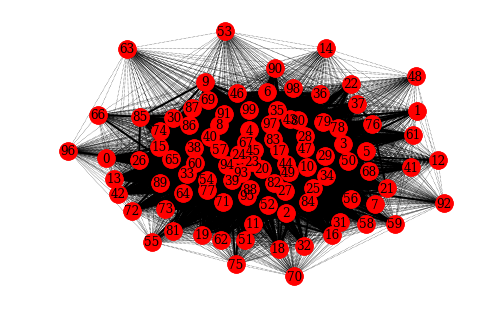

In [33]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [34]:
print(len(senReleasesDF.iloc[63]['text']),"words:","\n",senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

314 words: 
 FOR IMMEDIATE RELEASE

Senator Kennedy issued the following statement this evening following Senator Kerrys apology

John Kerry s statement says it all
I wish the Bush administration brought as much energy and focus to trying to correct their mistakes in Iraq as it did in going after John Kerry


In [35]:
print(len(senReleasesDF.iloc[23]['text']),"words:","\n",senReleasesDF.iloc[23]['text'].strip().replace('  ', '\n'))

20603 words: 
 FOR IMMEDIATE RELEASE
REID

 We re sorry that we re starting a little bit late
but the House has some votes going
and so Leader Pelosi will be here and Congresswoman Solis real soon

 I m reminded of the story I learned as a little boy
When the kid was watching the sheep and he was supposed to yell
Wolf
when the wolf was coming
And he yelled
Wolf
as we know

Wolf
Wolf
and there was never any wolf
And finally when a wolf showed up
no one came

 And no matter how hard we try to be bipartisan here in Washington
with President Bush it s the proverbial cry for wolf

 As I said leaving the chamber last night
whatever he says
it s just the opposite

 And we re here today to talk about health care
But the cry of wolf is once again ringing in my ears because he keeps talking about how he wants to improve health care and we re now five years into this and there s been no improvement

 In fact
I hope the president mentions when he s in Tennessee today that there s almost a million 

Ah...those documents with the **most** words are unsprisingly the most central in this simple document network.

Now let's turn it around and look at the word-to-word network by documents. 

In [87]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4270
Number of edges: 2080405
Average degree: 974.4286


First, let's reduce the number of words to a manageable size.

In [88]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.9883402510568855

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 1250, then drop all the isolates:

In [54]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 1250])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
giant = max(nx.connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


A bit smaller now, Now, let's visualize it: 

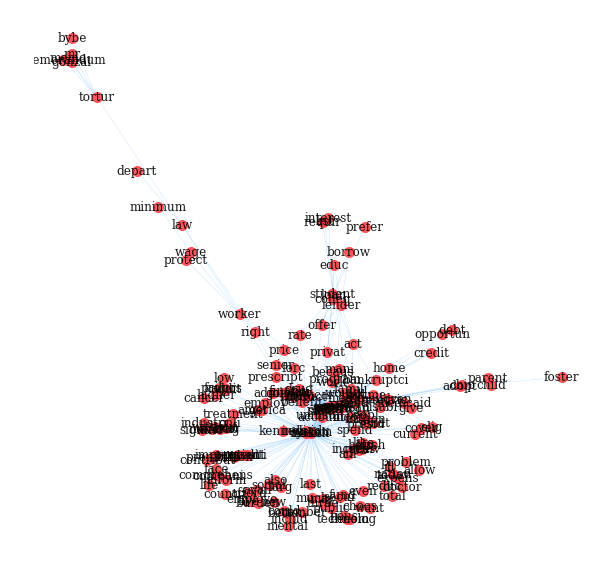

In [55]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score):

In [56]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


In [57]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [42]:
nx.clique.number_of_cliques(giant)['presid']

2

In [43]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

health, care, cost, plan, year, insur, save, provid, american, account, uninsur


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [44]:
americanNeighbors = giant.neighbors('american')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: SubGraph
Number of nodes: 22
Number of edges: 154
Average degree:  14.0000


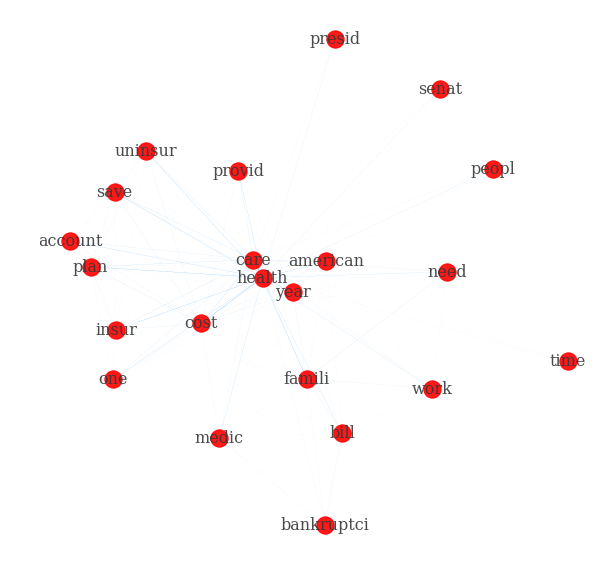

In [45]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [46]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [47]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: SubGraph
Number of nodes: 165
Number of edges: 474
Average degree:   5.7455


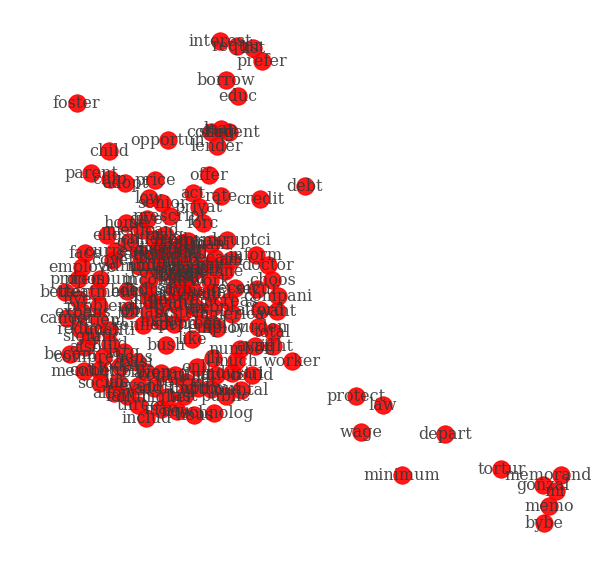

In [48]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render some reasonable networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that given insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

**In this homework, I intend to explore the semantic networks of Chinese Poetry from 1920s-1940s, which is regarded as a period that Chinese poetry tranformed from traditional to modern. To this end, I will focus on 1) what kinds of poems, words are most central to the semantic networks by laying out networks as well as calculating centralities; 2) what are the networks of nouns, verbs, noun-verb pair and noun-adjective pair in this corpus and 3) the ego network of the word "sky", which is one of the most common symbol used in Chinese poetry.**

### Chinese Modern Poetry Corpus (1920s-1940s)

Load data.

In [5]:
poem_1 = pandas.read_excel('../data/poem-before50.xls', index_col=0)

In [6]:
poem_1.head(2)

poet-age poem-name  \
poet-name                       
刘大白            2020     秋江的晚上   
刘大白            2020    旧梦（节选）   

                                                   poem-text  
poet-name                                                     
刘大白        归巢的鸟儿，\n  尽管是倦了，\n  还驮着斜阳回去。\n\n  双翅一翻，\n  把斜阳...  
刘大白        五\n\n  最能教人醉的：\n  酒吧，\n  青春吧；\n  但总不如夜深时琉璃也似的月...

Tokenize the data and remove the stopwords

In [7]:
#set the path of stopwords
stopwords_path = '../data/stopwords.txt'

In [8]:
# Define a function to tokenize and remove stopwords
def jiebaTokenize(text):
    result_words = []
    f_stop = open(stopwords_path)
    try:
        f_stop_text = f_stop.read( )
    finally:
        f_stop.close( )
    f_stop_seg_list=f_stop_text.split('\n')
    if not pandas.isnull(text):
        result = jieba.cut(text, cut_all=False)
        for r in result:
            if len(r.strip())>1 and not(r.strip() in f_stop_seg_list):
                result_words.append(r)
        return result_words
    else:
        return np.array([])

In [9]:
poem_1['jieba_tokenized'] = poem_1['poem-text'].apply(lambda x: jiebaTokenize(x) )

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/bj/v89n36091c9894hp0l9r5hgm0000gn/T/jieba.cache
Loading model cost 1.086 seconds.
Prefix dict has been built succesfully.


In [7]:
poem_1[:5]

poet-age poem-name  \
poet-name                       
刘大白            2020     秋江的晚上   
刘大白            2020    旧梦（节选）   
刘大白            2020        邮吻   
刘大白            2020    秋夜湖心独坐   
刘大白            2020     心上的写真   

                                                   poem-text  \
poet-name                                                      
刘大白        归巢的鸟儿，\n  尽管是倦了，\n  还驮着斜阳回去。\n\n  双翅一翻，\n  把斜阳...   
刘大白        五\n\n  最能教人醉的：\n  酒吧，\n  青春吧；\n  但总不如夜深时琉璃也似的月...   
刘大白        我不是不能用指头儿撕，\n  我不是不能用剪刀儿剖，\n  祇是缓缓地\n  　　轻轻地\n...   
刘大白        被秋光唤起，\n  孤舟独出，\n  向湖心亭上凭栏坐。\n  到三更，无数游船散了，\n ...   
刘大白        从低吟里，\n  短歌离了她底两唇，\n  飞行到我底耳际。\n  但耳际不曾休止，\n  ...   

                                             jieba_tokenized  
poet-name                                                     
刘大白        [归巢, 鸟儿, 尽管, 斜阳, 回去, 双翅, 一翻, 斜阳, 江上, 头白, 芦苇, 也...  
刘大白        [最能, 教人醉, 酒吧, 青春, 不如, 夜深, 琉璃, 似的, 月色, 心花, 不论, ...  
刘大白        [不是, 不能, 头儿, 不是, 不能, 剪刀, 儿剖, 缓缓, 轻轻地, 仔细, 挑开, ...  
刘大白        [被秋光, 唤起, 孤舟, 独出, 湖心亭, 凭栏, 无数, 游船, 天心, 一月, 湖心,...  
刘大白        [低吟, 短歌, 两唇, 飞行, 我底, 耳际, 耳际, 不曾, 休止, 毕竟, 颤动, 我...

### Two-mode Network

Firtly, we can build a two-mode network using document-word frequency matrix.

In [41]:
poemVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = jiebaTokenize)
poemVects_incidence = poemVectorizer.fit_transform(poem_1['poem-text'][:100])

In [42]:
poemVects_incidence.shape

(100, 3943)

Turn the incidence matrix into a network

In [43]:
g_2mode_poem = nx.Graph()

#define all the nodes
g_2mode_poem.add_nodes_from((poemVectorizer.get_feature_names()[i] for i in range(poemVects_incidence.shape[1])), bipartite = 'word')
g_2mode_poem.add_nodes_from(range(poemVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode_poem.add_edges_from(((d, poemVectorizer.get_feature_names()[w], {'weight' : poemVects_incidence[d, w]}) for d, w in zip(*poemVects_incidence.nonzero())))

In [44]:
print(nx.info(g_2mode_poem))

Name: 
Type: Graph
Number of nodes: 4043
Number of edges: 5531
Average degree:   2.7361


Plot the bipartitie network using the Fruchterman-Reingold Algorithm 

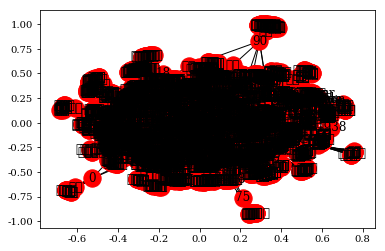

In [129]:
nx.draw_networkx(g_2mode_poem)

This network is not very informative

#### Document Network

Now, I will transform the two-mode network into the one-mode network of documents. The two-mode network enables documents to be connected to other documents via the words they share:

In [45]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode_poem.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode_poem.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

Firstly, let's construct the document to document network, by using the words they share:

In [46]:
gDoc_poem = contractNetwork(g_2mode_poem, 'doc')

In [47]:
print(nx.info(gDoc_poem))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 2353
Average degree:  47.0600


Visualize this doc-doc network

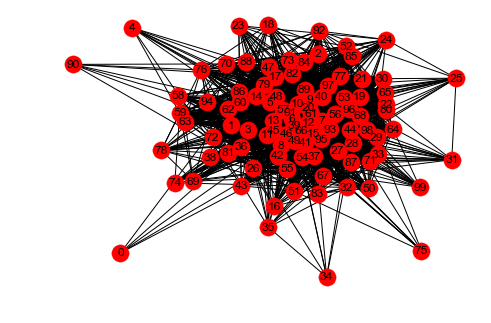

In [48]:
layout = nx.spring_layout(gDoc_poem, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc_poem, pos = layout, labels = {n:n for n in gDoc_poem.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

In [50]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc_poem.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc_poem.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc_poem.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc_poem, pos = layout, labels = {n:n for n in gDoc_poem.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc_poem, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

We can see that poem 0 and poem 90 are on the outside, while 39 and 20 are in the center of the network. Let's look into the poem text.

In [68]:
print(len(poem_1.iloc[0]['poem-text']),"words:","\n",poem_1.iloc[0]['poem-text'].strip().replace('  ', '\n'))

68 words: 
 归巢的鸟儿，

尽管是倦了，

还驮着斜阳回去。


双翅一翻，

把斜阳掉在江上；

头白的芦苇，

也妆成一瞬的红颜了。


In [69]:
print(len(poem_1.iloc[90]['poem-text']),"words:","\n",poem_1.iloc[90]['poem-text'].strip().replace('  ', '\n'))

180 words: 
 看一回凝静的桥影，
数一数螺钿的波纹，
我倚暖了石栏的青苔，
青苔凉透了我的心坎；

月儿，你休学新娘羞，
把锦被掩盖你光艳首，
你昨宵也在此勾留，
可听她允许今夜来否？

听远村寺塔的钟声，
象梦里的轻涛吐复收，
省心海念潮的涨歇，
依稀漂泊踉跄的孤舟！

水粼粼，夜冥冥，思悠悠，
何处是我恋的多情友，
风飕飕，柳飘飘，榆钱斗斗，
令人长忆伤春的歌喉。


In [70]:
print(len(poem_1.iloc[39]['poem-text']),"words:","\n",poem_1.iloc[39]['poem-text'].strip().replace('  ', '\n'))

2231 words: 
 零下八度的天气，
结着七十里路的坚冰，
阻碍着我愉快的归路
水路不得通，
旱路也难走。
冰！
我真是奈何你不得！
我真是无可奈何！

无可奈何，
便与撑船的商量，
预备着气力，
预备着木槌，
来把这坚冰打破！
冰！
难道我与你，
有什么解不了的冤仇？
只是我要赶我的路，
便不得不打破了你，
待我打破了你，
便有我一条愉快的归路。

撑船的说「可以」！
我们便提起精神，
合力去做──
是合着我们五个人的力，
三人一班的轮流着，
对着那艰苦的，不易走的路上走！

有几处的冰，
多谢先走的人，
早已代替我们打破；
只剩着浮在水面上的冰块儿，
轧轧的在我们船底下剉过，
其余的大部份，
便须让我们做「先走的」：
我们打了十槌八槌，
只走上一尺八寸的路
但是，
打了十槌八槌，
终走上了一尺八寸的路！
我们何妨把我们痛苦的喘息声，
欢欢喜喜的，
改唱我们的「敲冰胜利歌」。

敲冰！敲冰！
敲一尺，进一尺！
敲一程，进一程！
懒怠者说：
「朋友，歇歇罢！
何苦来？」
请了！
你歇你的，
我们走我们的路！
怯弱者说：
「朋友，歇歇罢！
不要敲病了人，
刮破了船。」
多谢！
这是我们想到，却不愿顾到的！
缓进者说：
「朋友，
一样的走，何不等一等？
明天就有太阳了。」
假使一世没有太阳呢？
「那么，傻孩子！
听你们去罢！」
这就很感谢你。

敲冰！敲冰！
敲一尺，进一尺！
敲一程，进一程！
这个兄弟倦了么？──
便有那个休息着的兄弟来换他。
肚子饿了么？──
有黄米饭，
有青菜汤。
口喝了么？──
冰底下有无量的清水；
便是冰块，
也可以烹作我们的好茶。
木槌的柄敲断了么？
那不打紧，
舱中拿出斧头来，
岸上的树枝多着。
敲冰！敲冰！
我们一切都完备，
一切不恐慌，
感谢我们的恩人自然界。

敲冰！敲冰！
敲一尺，进一尺！
敲一程，进一程！
从正午敲起，
直敲到漆黑的深夜。
漆黑的深夜，
还是点着灯笼敲冰。
刺刺的北风，
吹动两岸的大树，
化作一片怒涛似的声响。
那使是威权么？
手掌麻木了，
皮也剉破了；
臂中的筋肉，
伸缩渐渐不自由了；
脚也站得酸痛了；
头上的汗，
涔涔的向冰冷的冰上滴，
背上的汗，
被冷风被袖管中钻进去，
吹得快要结成冰冷的冰；
那便是痛苦么？
天上的黑云，
偶然有些破缝，
露出一颗两颗的星，
闪闪缩缩，
像对着我们霎眼，
那便是希望么

**Seems like the poem with more words are tend to locate in the center of the network, because they share more common words with other poems.**

### Word co-occurrence network

Next, let's look at the word network based on word co-occurrence

In [10]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    #for sent in sentences:
        
    words |= set(sentences)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    
    for i, word1 in enumerate(sentences):
        word1Index = wordIndices[word1]
        for word2 in sentences[i + 1:]:
            coOcMat[word1Index][wordIndices[word2]] += 1
    
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

Make the word co-occurrence matrix for first 100 poems in the corpus

In [33]:
g_poem = wordCooccurrence(poem_1['jieba_tokenized'][:100].sum())

In [35]:
g_poem2 = g_poem.copy()

In [34]:
len(g_poem)

3944

Total number of vertices

In [63]:
len(g_poem.nodes)

3944

Total number of edges

In [64]:
len(g_poem.edges)

7776780

This shows a part of adjacency matrix

In [65]:
nx.to_numpy_matrix(g_poem)[15:20, 15:20]

matrix([[0., 3., 1., 1., 3.],
        [3., 6., 3., 3., 9.],
        [1., 3., 0., 1., 3.],
        [1., 3., 1., 0., 3.],
        [3., 9., 3., 3., 6.]])

In [248]:
# export as csv file to read into gephi
words = list(nx.nodes(g_poem))
net = nx.to_numpy_matrix(g_poem)
netDF = pandas.DataFrame(net, columns = words, index = words)
netDF.to_csv("poem_matrix1.csv")

In [255]:
nx.write_gexf(g_poem,'poem1.gexf')

Filter the network by droping all the edges with weight below 1250, then drop all the isolates:

In [51]:
g_poem.remove_edges_from([(n1, n2) for n1, n2, d in g_poem.edges(data = True) if d['weight'] <= 1250])
g_poem.remove_nodes_from(list(nx.isolates(g_poem))) #since we are changing the graph list() evaluates the isolates first
giant_poem = max(nx.connected_component_subgraphs(g_poem), key=len) # keep just the giant connected component
print(nx.info(giant_poem))

Name: 
Type: Graph
Number of nodes: 60
Number of edges: 107
Average degree:   3.5667


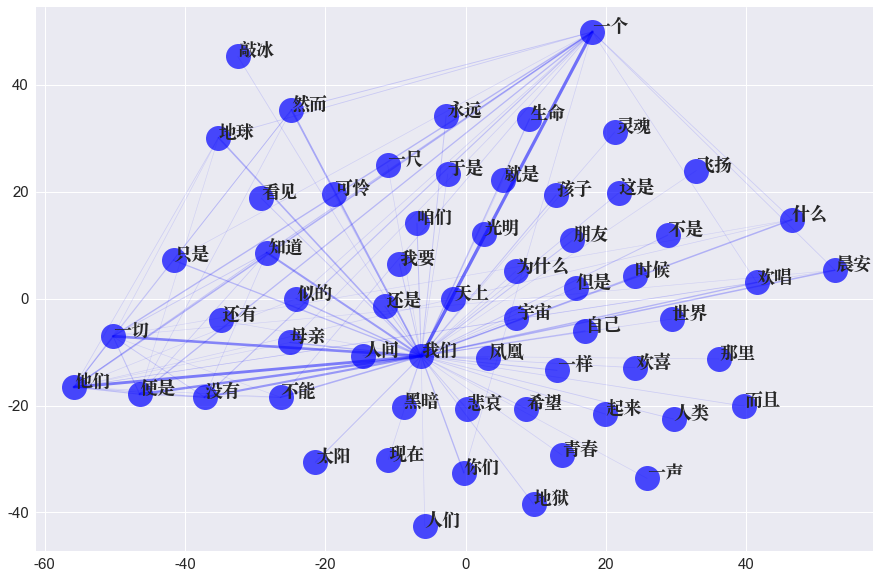

In [52]:
TSNE_based_network_plot(giant_poem)

We can see that the word **WE** is in the center of the network. But the other words seems to show no huge difference. Let's adjust the filtering process by just drop the all the edges with weight below 800.

In [53]:
g_poem2.remove_edges_from([(n1, n2) for n1, n2, d in g_poem2.edges(data = True) if d['weight'] <= 800])
g_poem2.remove_nodes_from(list(nx.isolates(g_poem2))) #since we are changing the graph list() evaluates the isolates first
giant_poem2 = max(nx.connected_component_subgraphs(g_poem2), key=len) # keep just the giant connected component
print(nx.info(giant_poem2))

Name: 
Type: Graph
Number of nodes: 102
Number of edges: 268
Average degree:   5.2549


Visualization

In [224]:
TSNE_based_network_plot(giant_poem2)

This revised network is more informative. We can see that **"WE" is still the word that connects with most of words**. And the **most central component that has most ties with other words includes "one", "everyting", "they", "know" and "no"**. And this network shows **a pattern of clustering (although not so obvious) based on the intensity of passion**. The cluster on the left top are words show more passion and vitality like "life", "sun", "kid", "mother", "sing", "friend" and "I want". The cluster on the right bottom contains words that are more neutral or negative like "empty", "silence", "dust", "night", "dont want", "poor", and symbols that have more complicated meanings like "moonlight", "sky", "grass", "breeze".

Moreover, we can find cliques, or completely connected sets of nodes. Let's the clique around the word **WE**.

In [61]:
nx.clique.number_of_cliques(giant_poem2)['我们'] # we

93

In [62]:
print(', '.join(max(nx.clique.find_cliques(giant_poem2), key = lambda x: len(x))))

我们, 一个, 他们, 一切, 便是, 没有, 知道, 然而, 地球, 不能


The words with most cliques including 'we','one','they','all','so','know','no','earth'

Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of THEY. 

In [83]:
theyNeighbors = giant_poem2.neighbors('他们')
g_they = giant_poem2.subgraph(theyNeighbors)
print(nx.info(g_they))

Name: 
Type: SubGraph
Number of nodes: 36
Number of edges: 193
Average degree:  10.7222


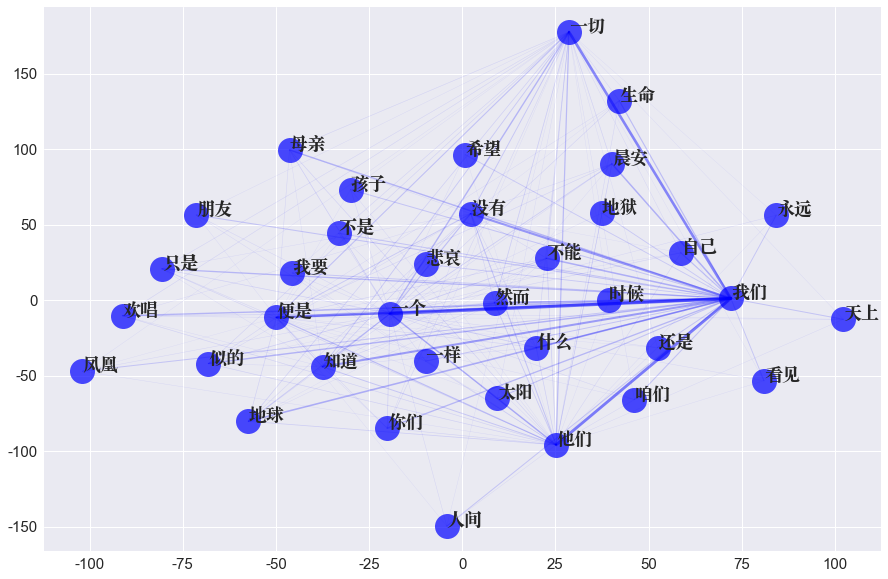

In [86]:
TSNE_based_network_plot(g_they)

We can see that because the words "we" is so central to the whole network, so the subgraph of "they" is highly overlapped with the network of "we", which means that words related to "they" are also related to "we".

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [88]:
dcentralities = nx.degree_centrality(giant)

NameError: name 'giant' is not defined

In [78]:
dcentralities['senat']

0.048484848484848485

In [79]:
max(dcentralities.items(), key = lambda x : x[1])

('health', 0.8242424242424242)

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

In [89]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

NetworkXError: Node 'save' has no position.

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

NetworkXError: Node 'save' has no position.

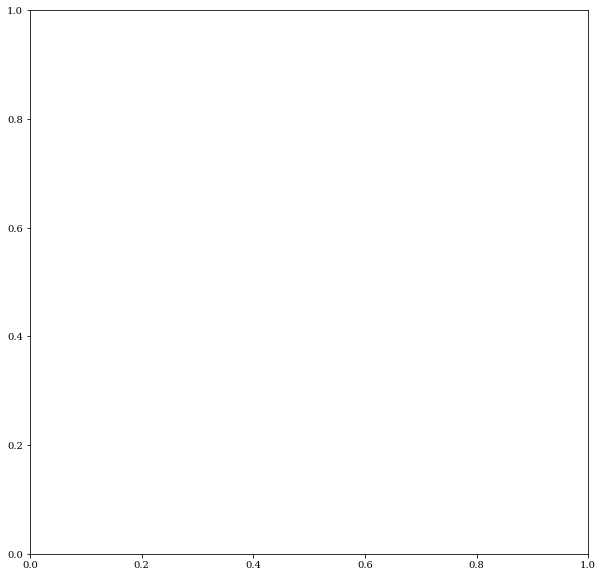

In [90]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

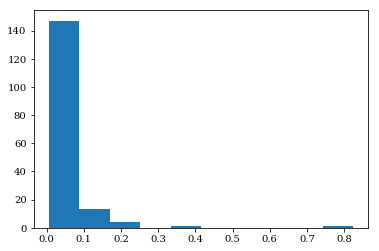

In [91]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [92]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.8242424242424242),
 ('care', 0.36363636363636365),
 ('cost', 0.23636363636363636),
 ('famili', 0.19393939393939394),
 ('children', 0.17575757575757575),
 ('year', 0.1696969696969697),
 ('plan', 0.15757575757575756),
 ('medicar', 0.1393939393939394),
 ('american', 0.1393939393939394),
 ('bill', 0.13333333333333333)]

In [93]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('compani', 0.006060606060606061),
 ('averag', 0.006060606060606061),
 ('secur', 0.006060606060606061),
 ('higher', 0.006060606060606061),
 ('without', 0.006060606060606061),
 ('may', 0.006060606060606061),
 ('today', 0.006060606060606061),
 ('technolog', 0.006060606060606061),
 ('improv', 0.006060606060606061),
 ('contribut', 0.006060606060606061)]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [94]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [95]:
centralities['senat']

3.695491500369549e-05

In [96]:
max(centralities.items(), key = lambda x : x[1])

('health', 0.7974546258832458)

We can color and size the nodes by betweenness centrality:

NetworkXError: Node 'save' has no position.

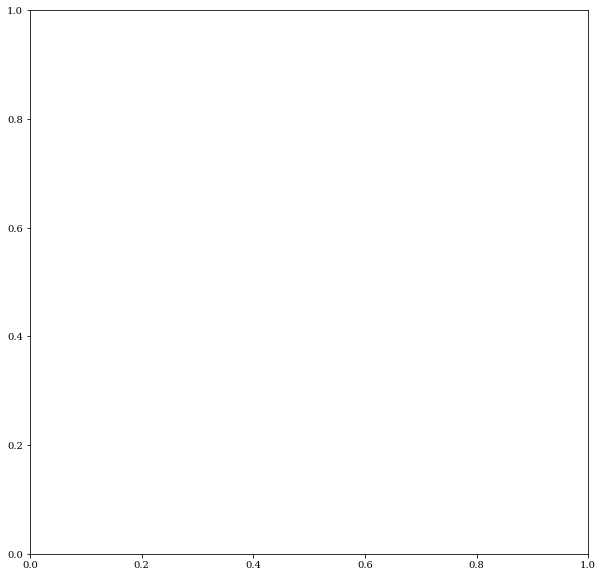

In [97]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

In [98]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [99]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.8242424242424242),
 ('care', 0.36363636363636365),
 ('cost', 0.23636363636363636),
 ('famili', 0.19393939393939394),
 ('children', 0.17575757575757575),
 ('year', 0.1696969696969697),
 ('plan', 0.15757575757575756),
 ('medicar', 0.1393939393939394),
 ('american', 0.1393939393939394),
 ('bill', 0.13333333333333333)]

What are words lower down?

In [100]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('wage', 0.024242424242424242),
 ('tax', 0.024242424242424242),
 ('mr', 0.024242424242424242),
 ('system', 0.024242424242424242),
 ('individu', 0.024242424242424242),
 ('prescript', 0.024242424242424242),
 ('high', 0.024242424242424242),
 ('deduct', 0.024242424242424242),
 ('mani', 0.01818181818181818),
 ('medicaid', 0.01818181818181818)]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [101]:
centralities = nx.closeness_centrality(giant)

NetworkXError: Node 'save' has no position.

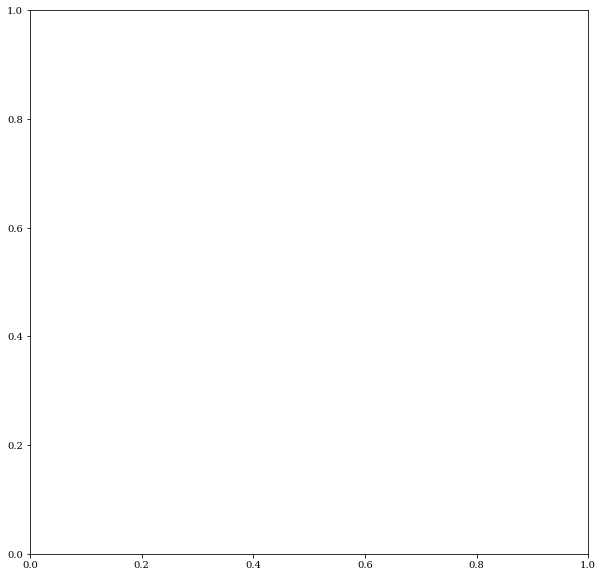

In [102]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [103]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.7638888888888888),
 ('care', 0.559322033898305),
 ('cost', 0.5092592592592593),
 ('famili', 0.5045871559633027),
 ('year', 0.4881656804733728),
 ('children', 0.4881656804733728),
 ('work', 0.4824561403508772),
 ('plan', 0.48104956268221577),
 ('bill', 0.4796511627906977),
 ('medicar', 0.4782608695652174)]

In [104]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('list', 0.26357827476038337),
 ('prefer', 0.26357827476038337),
 ('tortur', 0.25152439024390244),
 ('depart', 0.24774774774774774),
 ('minimum', 0.24193548387096775),
 ('gonzal', 0.20195838433292534),
 ('mr', 0.20146520146520147),
 ('memorandum', 0.20146520146520147),
 ('memo', 0.20146520146520147),
 ('bybe', 0.20121951219512196)]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [105]:
centralities = nx.eigenvector_centrality(giant)

NetworkXError: Node 'save' has no position.

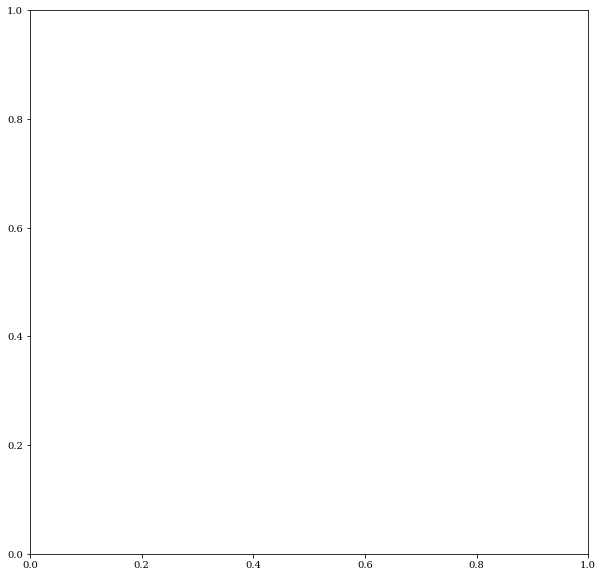

In [106]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

In [107]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [108]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.40940548651464004),
 ('care', 0.31410360905649326),
 ('cost', 0.2637118472565169),
 ('year', 0.22637895749862913),
 ('famili', 0.20307993427970322),
 ('plan', 0.19108150428848958),
 ('american', 0.18794543829229582),
 ('bill', 0.17714627787143095),
 ('insur', 0.17568249050178814),
 ('medicar', 0.16513397986452114)]

In [109]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('list', 0.001172954008867934),
 ('prefer', 0.001172954008867934),
 ('tortur', 0.00022811912384458795),
 ('depart', 0.00022454856713851977),
 ('minimum', 9.793307562753288e-05),
 ('gonzal', 1.4632892023819261e-05),
 ('mr', 1.3319282015842171e-05),
 ('memorandum', 1.2626439035859934e-05),
 ('memo', 1.2626439035859934e-05),
 ('bybe', 1.1865270167541129e-05)]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [110]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [111]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 111
Average degree:   8.8800


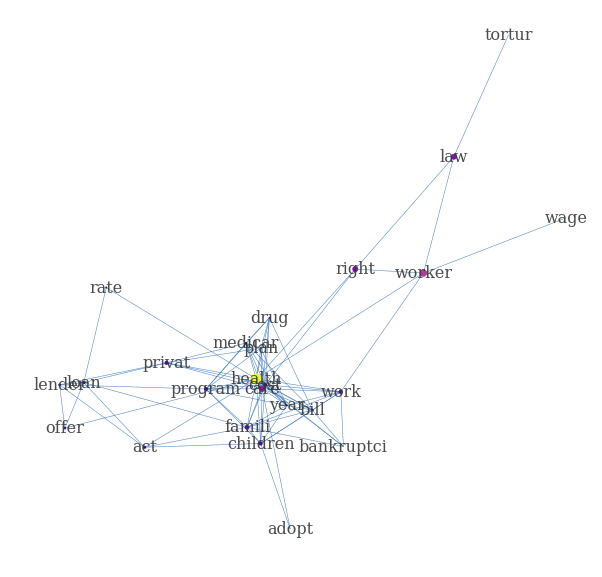

In [112]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [113]:
nx.density(giant)

0.0362175976633808

We can also calculate the average degree per node:

In [114]:
np.mean([v for w,v in nx.degree(giant)])

5.975903614457831

The diameter calculates the average distance between any two nodes in the network:

In [115]:
nx.diameter(giant)

7

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In this part, I failed to draw plot of centrality because I cannot make Python read Chinese and failed to modify the TSNE function... However, based on the results of calculation and sorting, we can still learn about the semantic structure of our corpus since words with most centrality in this corpus is pretty obvious.

### Centrality

#### Degree Centrality

In [95]:
dcentralities_poem = nx.degree_centrality(giant_poem)

In [96]:
dcentralities_poem['太阳']# 'Sun'

0.01694915254237288

In [97]:
max(dcentralities_poem.items(), key = lambda x : x[1])

('我们', 1.0338983050847457)

**The word with max deree centrality is "WE", wich is consistent with what we find from the first assignment.**

Make plot by using size to represent degree centrality and edge weight

In [137]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities_poem.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_poem.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_poem.edges(data = True)))
nx.draw(giant_poem, ax = ax, pos = layout, labels = {n:n for n in giant_poem.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord_poem.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities_poem[n] / maxC for n in giant_poem.nodes],
        node_size = [dcentralities_poem[n] / maxC * 200 for n in giant_poem.nodes],
        cmap = plt.get_cmap('plasma'))

Let's see the distribution of degree centrality:

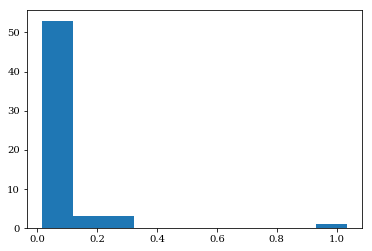

In [138]:
plt.hist(list(dcentralities_poem.values()))
plt.show()

Specifically, let's look at the top and bottom ten words:

In [139]:
sorted(dcentralities_poem.items(), key = lambda x: x[1], reverse = True)[:10]

[('我们', 1.0338983050847457),
 ('一个', 0.3050847457627119),
 ('他们', 0.2711864406779661),
 ('一切', 0.22033898305084745),
 ('便是', 0.1864406779661017),
 ('没有', 0.13559322033898305),
 ('知道', 0.13559322033898305),
 ('然而', 0.0847457627118644),
 ('地球', 0.0847457627118644),
 ('不能', 0.0847457627118644)]

In [140]:
sorted(dcentralities_poem.items(), key = lambda x: x[1], reverse = True)[-10:]

[('希望', 0.01694915254237288),
 ('孩子', 0.01694915254237288),
 ('世界', 0.01694915254237288),
 ('一声', 0.01694915254237288),
 ('人类', 0.01694915254237288),
 ('还有', 0.01694915254237288),
 ('现在', 0.01694915254237288),
 ('还是', 0.01694915254237288),
 ('人间', 0.01694915254237288),
 ('于是', 0.01694915254237288)]

**The top words of degree centrality includes "we", "one", "they", "all", "no", "know" and "earth". But it is worth mention that "we" is significantly central to the network, while other words' centralities are all much smaller than it.**

#### Betweenness Centrality

In [99]:
centralities_poem = nx.betweenness.betweenness_centrality(giant_poem)

In [143]:
centralities_poem['太阳']

0.0

In [142]:
max(centralities_poem.items(), key = lambda x : x[1])

('我们', 0.946551724137931)

Color and size the nodes by betweeness centrality

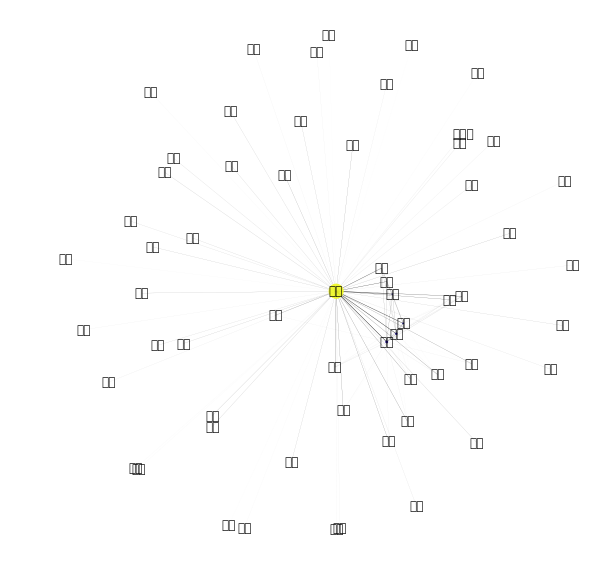

In [144]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_poem.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_poem.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_poem.edges(data = True)))
nx.draw(giant_poem, ax = ax, pos = layout, labels = {n:n for n in giant_poem.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_poem.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_poem[n] / maxC for n in giant_poem.nodes],
        node_size = [centralities_poem[n] / maxC * 200 for n in giant_poem.nodes],
        cmap = plt.get_cmap('plasma'))

Distribution of betweenness centrality:

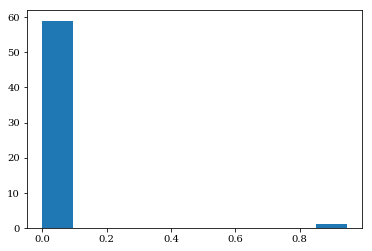

In [145]:
plt.hist(list(centralities_poem.values()))
plt.show()

In [225]:
sorted(centralities_poem.items(), key = lambda x: x[1], reverse = True)[:5]

[('我们', 0.946551724137931),
 ('一个', 0.016686148451198125),
 ('他们', 0.008796025715955582),
 ('一切', 0.0029514903565166567),
 ('便是', 0.0010520163646990065)]

The result of betweenness centrality is same as degree centrality

#### Closeness Centrality

In [100]:
Ccentralities_poem = nx.closeness_centrality(giant_poem)

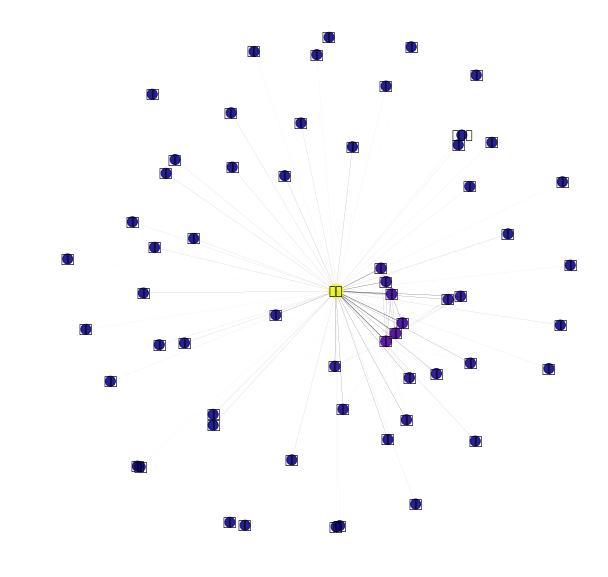

In [148]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(Ccentralities_poem.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_poem.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_poem.edges(data = True)))
nx.draw(giant_poem, ax = ax, pos = layout, labels = {n:n for n in giant_poem.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_poem.edges(data = True)], 
        alpha = .9, 
        node_color = [Ccentralities_poem[n] / maxC for n in giant_poem.nodes],
        node_size = [Ccentralities_poem[n] / maxC * 200 for n in giant_poem.nodes],
        cmap = plt.get_cmap('plasma'))

In [149]:
sorted(Ccentralities_poem.items(), key = lambda x: x[1], reverse = True)[:10]

[('我们', 1.0),
 ('一个', 0.5784313725490197),
 ('他们', 0.5673076923076923),
 ('一切', 0.5514018691588785),
 ('便是', 0.5412844036697247),
 ('没有', 0.5267857142857143),
 ('知道', 0.5267857142857143),
 ('然而', 0.5221238938053098),
 ('地球', 0.5221238938053098),
 ('不能', 0.5221238938053098)]

In [151]:
sorted(Ccentralities_poem.items(), key = lambda x: x[1], reverse = True)[-10:]

[('希望', 0.5042735042735043),
 ('孩子', 0.5042735042735043),
 ('世界', 0.5042735042735043),
 ('一声', 0.5042735042735043),
 ('人类', 0.5042735042735043),
 ('还有', 0.5042735042735043),
 ('现在', 0.5042735042735043),
 ('还是', 0.5042735042735043),
 ('人间', 0.5042735042735043),
 ('于是', 0.5042735042735043)]

The result of closeness centrality is also similar.

#### Eignvector Centrality

In [101]:
Ecentralities_poem = nx.eigenvector_centrality(giant_poem)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(Ecentralities_poem.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_poem.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_poem.edges(data = True)))
nx.draw(giant_poem, ax = ax, pos = layout, labels = {n:n for n in giant_poem.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_poem.edges(data = True)], 
        alpha = .9, 
        node_color = [Ecentralities_poem[n] / maxC for n in giant_poem.nodes],
        node_size = [Ecentralities_poem[n] / maxC * 200 for n in giant_poem.nodes],
        cmap = plt.get_cmap('plasma'))

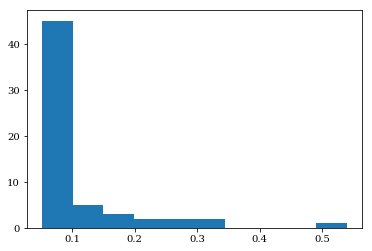

In [153]:
plt.hist(list(Ecentralities_poem.values()))
plt.show()

In [154]:
sorted(Ecentralities_poem.items(), key = lambda x: x[1], reverse = True)[:10]

[('我们', 0.5396752351935619),
 ('一个', 0.32499074802456657),
 ('他们', 0.3089923577996522),
 ('一切', 0.2764191887117341),
 ('便是', 0.2495893651567498),
 ('没有', 0.20241767991719178),
 ('知道', 0.20241767991719178),
 ('然而', 0.16347951183490647),
 ('地球', 0.16347951183490647),
 ('不能', 0.16347951183490647)]

Filter our network by a centrality measure

In [102]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [103]:
giant_poem_filtered30 = filterWords(giant_poem, minWeight=3, filter_='degree', rule='number', value_of_rule=25)
print(nx.info(giant_poem_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 72
Average degree:   5.7600


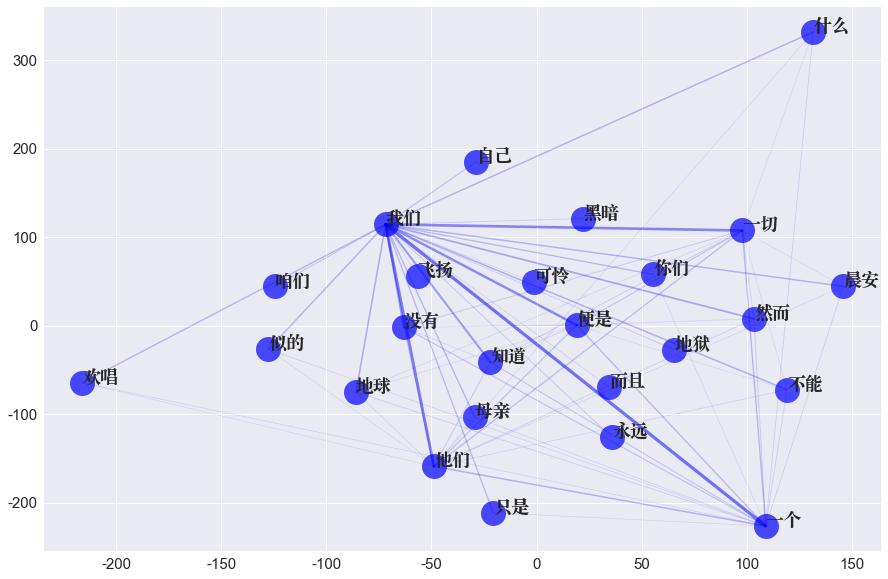

In [107]:
TSNE_based_network_plot(giant_poem_filtered30)

**Here we can see the network of 30 words that I filtered out based on degree centrality. "We" , "they", "one" and "all" are in the most central position in the network structure and have connected with most of the words. This finding is consistent with some feature of poetry like extreme expression ("all") and comparison(we & they, one & all").**

**A possible explanation for the highest centrality of "we" is that during 1920s-1940s, Chinese poetry was experiencing an ideological turn that expression about individual emotion was criticized and poets were required to pay attention to the fate of their people and nation (Xie, 2009).**

### Global Statistics

#### Density

In [161]:
nx.density(giant_poem)

0.060451977401129946

#### Average Degree

In [162]:
np.mean([v for w,v in nx.degree(giant_poem)])

3.566666666666667

#### Average Distance

In [163]:
nx.diameter(giant_poem)

2

# POS based networks

Now let's look at links between specific parts of speech within a network.

For this we will be using the `nltk` POS facilities instead of the Stanford ones. These are much faster, but also somewhat less accurate. (You get what you *pay* for in computational power).

Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [164]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col = 0)

In [165]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

author  over_18  score                subreddit  \
99  jimmy_three_shoes    False   4990  Tales From Tech Support   
98         badbfriend    False   5034            Relationships   
97             Fafrdr    False   5146            Relationships   

                                                 text  \
99  This happened a little while ago, when I was c...   
98  https://www.reddit.com/r/relationships/comment...   
97  First post: https://www.reddit.com/r/relations...   

                                                title  \
99   We've tried nothing, and we're all out of ideas!   
98  Me [29 M] with my g/f [27 F] together 4 years,...   
97  Update - My [16F] father [59M] acts creepy tow...   

                                                  url  \
99  https://www.reddit.com/r/talesfromtechsupport/...   
98  https://www.reddit.com/r/relationships/comment...   
97  https://www.reddit.com/r/relationships/comment...   

                                            sentences  
99  [[This, happened, a, little, while, ago, ,, wh...  
98  [[https, :, //www.reddit.com/r/relationships/c...  
97  [[First, post, :, https, :, //www.reddit.com/r...

Now we'll normalize the tokens through stemming:

In [166]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [167]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [168]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [169]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 2635
Number of edges: 26238
Average degree:  19.9150


This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [170]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 87
Number of edges: 1922
Average degree:  44.1839


And low weight edges:

In [171]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 87
Number of edges: 486
Average degree:  11.1724


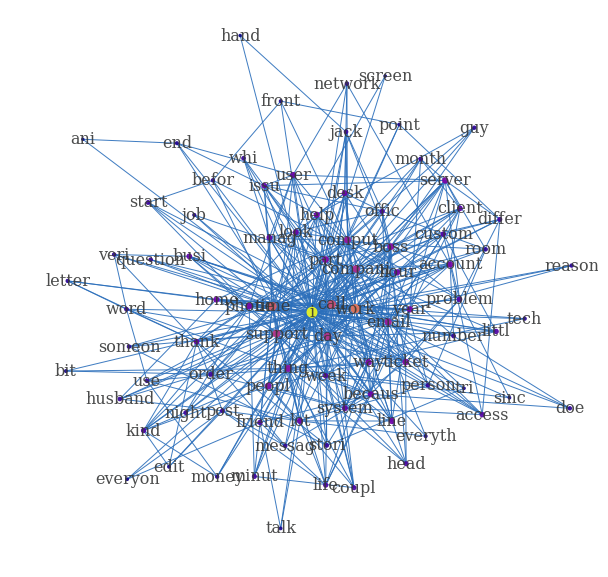

In [172]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

That is an interesting pattern; everyone is talking about themselves ("I...this", "I...that").

What if we want to look at noun-verb pairs instead?

In [173]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [174]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2871
Number of edges: 40611
Average degree:  28.2905


In [175]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [176]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2871
Number of edges: 13366
Average degree:   9.3110


Dropping low weight edges and low degree vertices gives us:

In [177]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [178]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 82
Number of edges: 450
Average degree:  10.9756


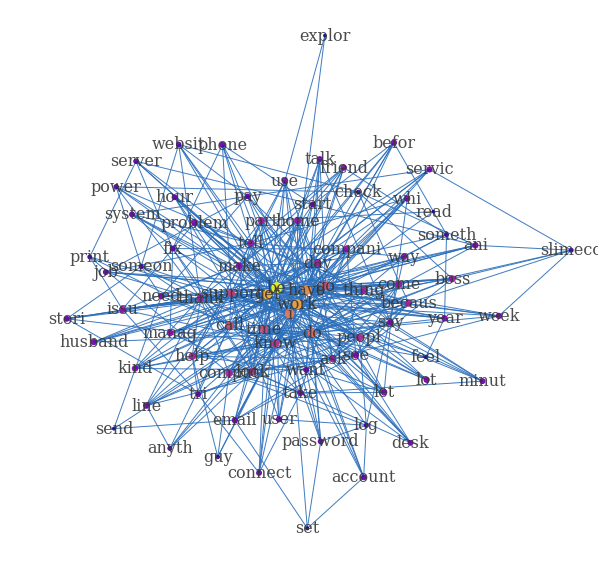

In [179]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, as we did before:

In [180]:
g_i = gNV.subgraph(['i'] + list(gNV.neighbors('i')))

In [181]:
print(nx.info(g_i))

Name: 
Type: SubGraph
Number of nodes: 34
Number of edges: 33
Average degree:   1.9412


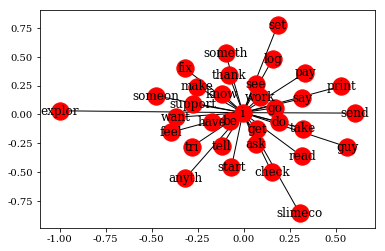

In [182]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'stori' for this:

In [183]:
storyNeighbors = gNV.neighbors('stori')
set(storyNeighbors)

{'be', 'get', 'know', 'someon', 'support', 'thank', 'tri'}

In [184]:
storyNeighbors = set(gNV.neighbors('stori'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [185]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: SubGraph
Number of nodes: 56
Number of edges: 161
Average degree:   5.7500


This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [186]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.8727272727272727),
 ('get', 0.7090909090909091),
 ('support', 0.39999999999999997),
 ('know', 0.36363636363636365),
 ('thank', 0.3090909090909091),
 ('tri', 0.14545454545454545),
 ('stori', 0.12727272727272726),
 ('someon', 0.12727272727272726),
 ('i', 0.12727272727272726),
 ('call', 0.12727272727272726)]

Or eigenvector centrality:

In [187]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.4392898420289854),
 ('get', 0.38266314108290184),
 ('support', 0.24421847103891117),
 ('know', 0.21111457825779464),
 ('thank', 0.1944299469011971),
 ('stori', 0.15627933587529896),
 ('i', 0.15627933587529896),
 ('call', 0.15627933587529896),
 ('issu', 0.14825532139380798),
 ('help', 0.14825532139380798)]

Notice that 'stori' isn't even in the top 5:

Lets plot it:

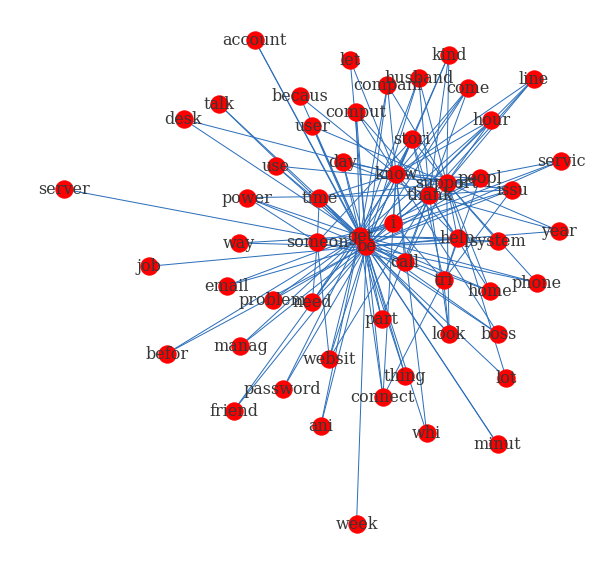

In [188]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

"I" is still in the middle. These are stories about the self.

Lets create a noun-adjective network:

In [189]:
gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 3114
Number of edges: 42799
Average degree:  27.4881


By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [190]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 74
Average degree:   5.9200


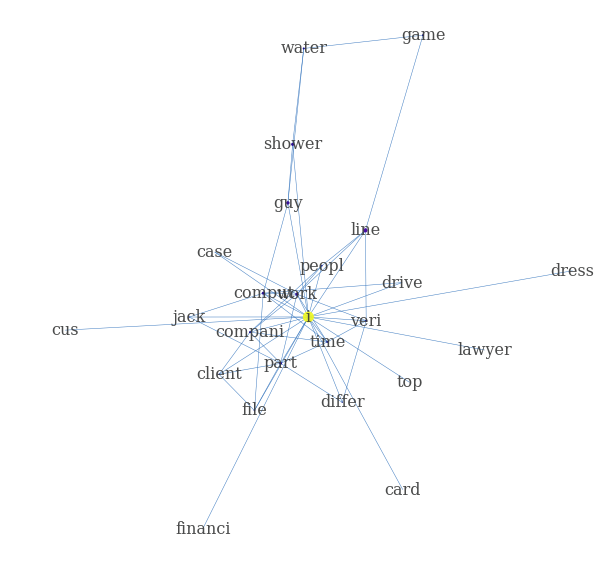

In [191]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

A truly self-centered network.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

In [108]:
import jieba.posseg as pseg

In [109]:
def tokenizePOS(text):
    result_words = []
    if not pandas.isnull(text):
        result = pseg.cut(text)
        for word,tag in result:
            result_words.append((word,tag))
        return result_words
    else:
        return np.array([])

In [110]:
poem_1['jieba_tokens_POS'] = poem_1['poem-text'].apply(lambda x: tokenizePOS(x) )

In [111]:
poem_1[:4]

poet-age poem-name  \
poet-name                       
刘大白            2020     秋江的晚上   
刘大白            2020    旧梦（节选）   
刘大白            2020        邮吻   
刘大白            2020    秋夜湖心独坐   

                                                   poem-text  \
poet-name                                                      
刘大白        归巢的鸟儿，\n  尽管是倦了，\n  还驮着斜阳回去。\n\n  双翅一翻，\n  把斜阳...   
刘大白        五\n\n  最能教人醉的：\n  酒吧，\n  青春吧；\n  但总不如夜深时琉璃也似的月...   
刘大白        我不是不能用指头儿撕，\n  我不是不能用剪刀儿剖，\n  祇是缓缓地\n  　　轻轻地\n...   
刘大白        被秋光唤起，\n  孤舟独出，\n  向湖心亭上凭栏坐。\n  到三更，无数游船散了，\n ...   

                                             jieba_tokenized  \
poet-name                                                      
刘大白        [归巢, 鸟儿, 尽管, 斜阳, 回去, 双翅, 一翻, 斜阳, 江上, 头白, 芦苇, 也...   
刘大白        [最能, 教人醉, 酒吧, 青春, 不如, 夜深, 琉璃, 似的, 月色, 心花, 不论, ...   
刘大白        [不是, 不能, 头儿, 不是, 不能, 剪刀, 儿剖, 缓缓, 轻轻地, 仔细, 挑开, ...   
刘大白        [被秋光, 唤起, 孤舟, 独出, 湖心亭, 凭栏, 无数, 游船, 天心, 一月, 湖心,...   

                                            jieba_tokens_POS  
poet-name                                                     
刘大白        [(归巢, nr), (的, uj), (鸟儿, n), (，, x), (\n, x), ...  
刘大白        [(五, m), (\n, x), (\n, x), ( , x), ( , x), (最,...  
刘大白        [(我, r), (不是, c), (不能, v), (用, p), (指, n), (头儿...  
刘大白        [(被, p), (秋光, nr), (唤起, v), (，, x), (\n, x), (...

In [112]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for poem in sentences:
        s = [(p.word, p.flag) for p in pseg.cut(''.join(poem)) if p.flag in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for poem in reducedSents:
        for i, word1 in enumerate(poem):
            word1Index = wordIndices[word1]
            for word2 in poem[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

#### Nouns Networks

In [143]:
gN = posCooccurrence(poem_1['jieba_tokenized'], 'n')

In [144]:
list(gN.nodes(data=True))[:10]

[('空桑', {'bipartite': 'n'}),
 ('我间', {'bipartite': 'n'}),
 ('幽会', {'bipartite': 'n'}),
 ('尘砂', {'bipartite': 'n'}),
 ('衣襟', {'bipartite': 'n'}),
 ('心愿', {'bipartite': 'n'}),
 ('青苗', {'bipartite': 'n'}),
 ('草纸', {'bipartite': 'n'}),
 ('荷花', {'bipartite': 'n'}),
 ('飞旋', {'bipartite': 'n'})]

In [145]:
print(nx.info(gN))

Name: 
Type: Graph
Number of nodes: 6466
Number of edges: 330787
Average degree: 102.3158


In [148]:
gN.remove_nodes_from([n for n in gN.nodes if len(set(gN.neighbors(n))) <= 325]) 
print(nx.info(gN))

Name: 
Type: Graph
Number of nodes: 19
Number of edges: 189
Average degree:  19.8947


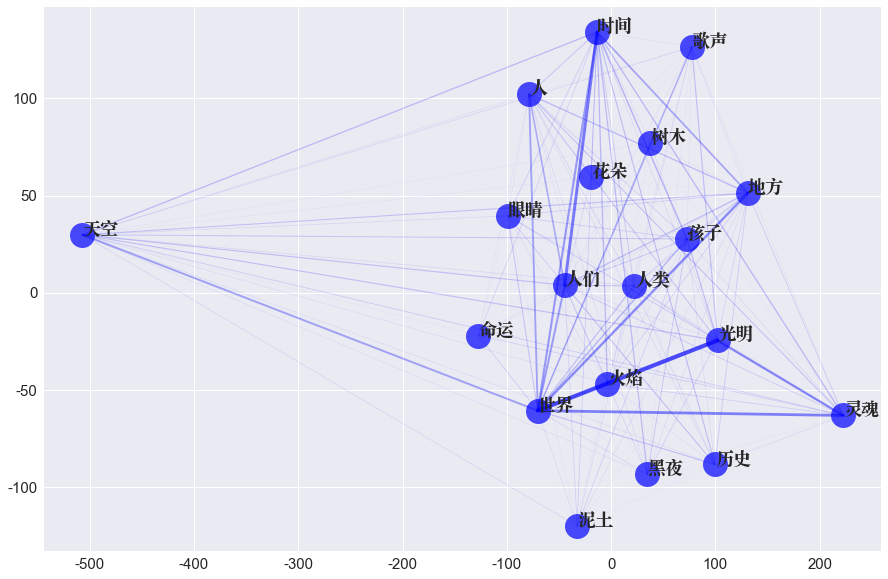

In [149]:
TSNE_based_network_plot(gN)

It is interesting that "world" and "soul" have a strong connection with "flame" and "light" but weakly connected to "night". This can be a reflection of Chinese poets' wishes that their nation can come over all the pains and humiliations in early 20th century and embrace a lightful future.

#### Verbs Network

In [153]:
gV = posCooccurrence(poem_1['jieba_tokenized'], 'v')

In [155]:
list(gV.nodes(data=True))[:10]

[('飞开', {'bipartite': 'v'}),
 ('做工', {'bipartite': 'v'}),
 ('笼盖', {'bipartite': 'v'}),
 ('呼求', {'bipartite': 'v'}),
 ('相爱', {'bipartite': 'v'}),
 ('奏鸣', {'bipartite': 'v'}),
 ('传来', {'bipartite': 'v'}),
 ('跌坏', {'bipartite': 'v'}),
 ('激变', {'bipartite': 'v'}),
 ('唤出', {'bipartite': 'v'})]

In [156]:
print(nx.info(gV))

Name: 
Type: Graph
Number of nodes: 5016
Number of edges: 270056
Average degree: 107.6778


In [158]:
gV.remove_nodes_from([n for n in gV.nodes if len(set(gV.neighbors(n))) <= 320]) 
print(nx.info(gV))

Name: 
Type: Graph
Number of nodes: 20
Number of edges: 210
Average degree:  21.0000


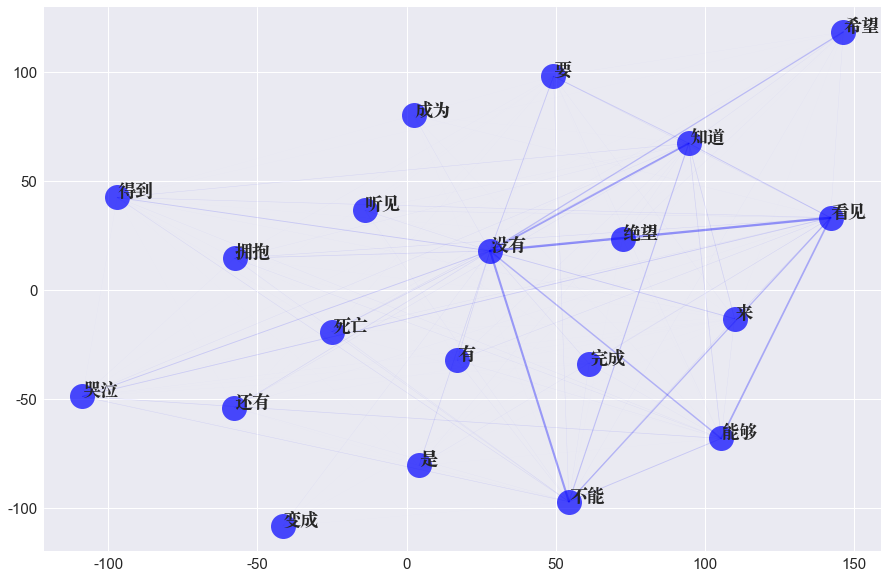

In [227]:
TSNE_based_network_plot(gV)

#### Noun-verb structure network

In [228]:
gNV = posCooccurrence(poem_1['jieba_tokenized'], 'n', 'v')

In [229]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 11456
Number of edges: 1189108
Average degree: 207.5957


In [230]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [232]:
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 350]) 
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 28
Number of edges: 132
Average degree:   9.4286


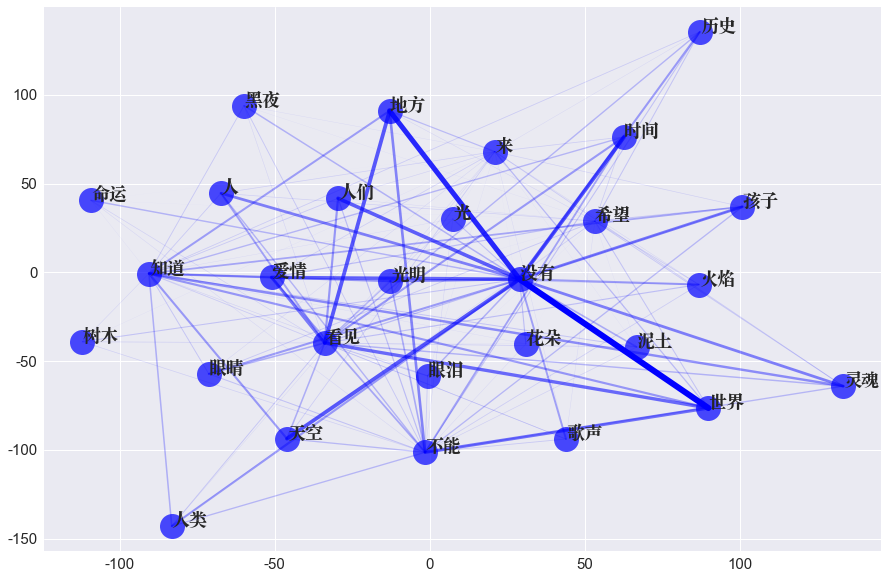

In [235]:
TSNE_based_network_plot(gNV)

In [257]:
gNA = posCooccurrence(poem_1['jieba_tokenized'], 'n', 'a')

In [258]:
print(nx.info(gNA))

Name: 
Type: Graph
Number of nodes: 7645
Number of edges: 521782
Average degree: 136.5028


In [259]:
gNA.remove_edges_from([(n1,n2) for n1,n2,d in gNA.edges(data = True) if gNA.nodes[n1]['bipartite'] == gNA.nodes[n2]['bipartite']])

In [260]:
gNA.remove_nodes_from([n for n in gNA.nodes if len(set(gNA.neighbors(n))) <= 420]) 
print(nx.info(gNA))

Name: 
Type: Graph
Number of nodes: 97
Number of edges: 450
Average degree:   9.2784


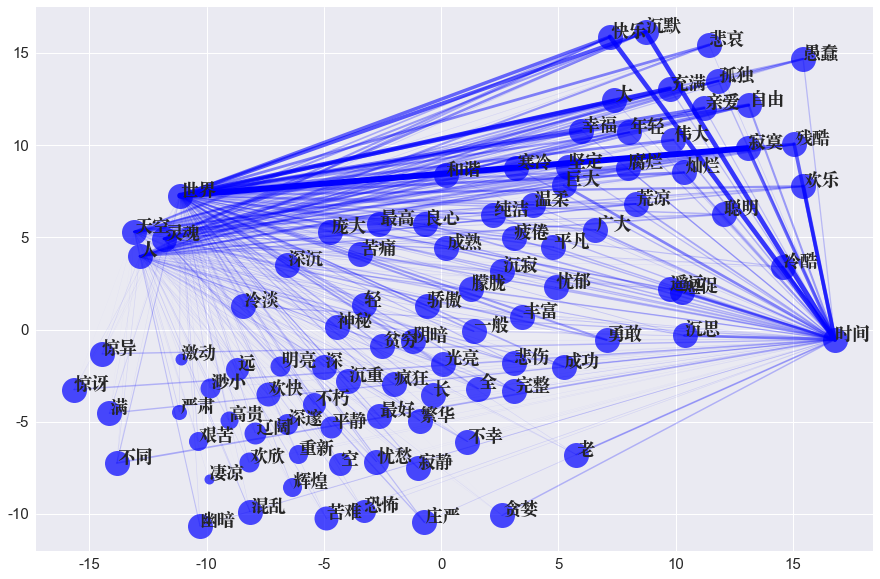

In [262]:
TSNE_based_network_plot(gNA)

**The noun-adjective network shows some interesting insights: 1) nouns go with adjectives are "world", "sky","soul", "person" and "time". 2) "World" has a very strong connection with "lonely", but at the meanwhile, also "happy" and "bless". 3) "Time" is most connected with "merciless" and "silent". 4) "Sky" represents "free" and "alone". By looking into this network, we can explore the semantic meaning the poets trying to convey using symbols, like sky.**

#### Ego Network

Let's see what words are happening around **SKY**, which is one of the most common symbol in modern poetry.

In [263]:
g_sky = gNA.subgraph(['天空'] + list(gNA.neighbors('天空')))

In [264]:
print(nx.info(g_sky))

Name: 
Type: SubGraph
Number of nodes: 91
Number of edges: 90
Average degree:   1.9780


Find all nodes connected to **SKY** within 2 hops

In [265]:
skyNeighbors = gNA.neighbors('天空')
set(skyNeighbors)

{'一般',
 '不同',
 '不幸',
 '不朽',
 '严肃',
 '丰富',
 '亲爱',
 '伟大',
 '充满',
 '光亮',
 '全',
 '冷淡',
 '冷酷',
 '凄凉',
 '勇敢',
 '和谐',
 '坚定',
 '大',
 '孤独',
 '完整',
 '寂寞',
 '寂静',
 '寒冷',
 '巨大',
 '平凡',
 '平静',
 '年轻',
 '幸福',
 '幽暗',
 '广大',
 '庄严',
 '庞大',
 '忧愁',
 '忧郁',
 '快乐',
 '恐怖',
 '悲伤',
 '悲哀',
 '惊异',
 '惊讶',
 '愚蠢',
 '成熟',
 '明亮',
 '最好',
 '最高',
 '朦胧',
 '欢乐',
 '欢快',
 '欢欣',
 '残酷',
 '沉寂',
 '沉思',
 '沉重',
 '沉默',
 '深',
 '深沉',
 '深邃',
 '混乱',
 '温柔',
 '渺小',
 '满',
 '激动',
 '灿烂',
 '疯狂',
 '疲倦',
 '短促',
 '神秘',
 '空',
 '繁华',
 '纯洁',
 '老',
 '聪明',
 '腐烂',
 '自由',
 '良心',
 '艰苦',
 '苦痛',
 '荒凉',
 '贪婪',
 '贫穷',
 '轻',
 '辉煌',
 '辽阔',
 '远',
 '遥远',
 '重新',
 '长',
 '阴暗',
 '骄傲',
 '高贵'}

In [266]:
skyNeighbors = set(gNA.neighbors('天空'))
skyNeighborsPlus1 = set(skyNeighbors)
for n in skyNeighbors:
    skyNeighborsPlus1 |= set(gNA.neighbors(n))

In [267]:
gNA_sky = gNA.subgraph(skyNeighborsPlus1)
print(nx.info(gNA_sky))

Name: 
Type: SubGraph
Number of nodes: 95
Number of edges: 442
Average degree:   9.3053


Use degree centrality to see the words most connected to sky

In [269]:
sorted(nx.degree_centrality(gNA_sky).items(), key = lambda x: x[1], reverse = True)[:10]

[('世界', 0.9574468085106382),
 ('天空', 0.9574468085106382),
 ('人', 0.9468085106382979),
 ('时间', 0.925531914893617),
 ('灵魂', 0.9148936170212766),
 ('幽暗', 0.05319148936170213),
 ('疯狂', 0.05319148936170213),
 ('满', 0.05319148936170213),
 ('远', 0.05319148936170213),
 ('空', 0.05319148936170213)]

In [270]:
TSNE_based_network_plot(gNA_sky)

Nouns connected to **SKY** includes **world, person, time, soul**, and adjective conntected to it includes **dark, crazy, full, far and empty**

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [209]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [210]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [211]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [212]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

In [213]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [214]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [215]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [216]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [217]:
df_mean

Juror 8   Juror 3  Juror 10   Foreman   Juror 7   Juror 4  \
Juror 8   0.000000  3.757957  8.089079  0.930180  5.167497  0.794645   
Juror 3   8.529312  0.000000  6.673916  4.150076  2.534751  4.902852   
Juror 10  8.413188  7.427932  0.000000  4.540236  3.216307  1.030049   
Foreman   1.137060  0.612615  1.945196  0.000000  1.521390  0.834870   
Juror 7   2.603853  5.901169  0.648844  1.969868  0.000000  1.110101   
Juror 4   5.791320  0.200669  0.266484  0.582956  0.094200  0.000000   
Juror 11  0.378515  0.544628  0.779340  0.454645  0.290575  0.447512   
Juror 12  5.961338  0.695831  0.519459  1.253033  0.247939  0.162463   
Juror 6   4.526244  0.923784  0.503503  1.049825  1.288920  0.451562   
Juror 2   0.583732  2.303417  0.529583  1.722894  2.005939  0.299311   
Juror 9   1.216641  1.281288  0.967587  1.675483  1.657341  1.681338   
Juror 5   0.552951  1.001575  0.696393  1.180245  1.180355  0.497265   

          Juror 11  Juror 12   Juror 6   Juror 2   Juror 9   Juror 5  
Juror 8   0.845335  1.336329  6.106684  0.916765  6.385205  7.300776  
Juror 3   1.092571  0.509942  3.825015  3.861767  0.266426  1.561626  
Juror 10  1.004598  0.529232  2.426582  0.407460  1.233599  0.885871  
Foreman   1.338554  3.230634  1.013511  3.534036  1.311436  4.115411  
Juror 7   0.279870  0.608548  1.047693  2.910670  1.619475  1.570038  
Juror 4   3.347982  0.316963  0.300770  2.112033  0.370973  0.673364  
Juror 11  0.000000  0.614536  0.821143  0.951222  0.476986  0.844157  
Juror 12  0.388620  0.000000  2.500976  2.375977  0.481394  0.834032  
Juror 6   0.375776  0.904313  0.000000  2.861587  0.905421  0.310822  
Juror 2   0.652302  1.623813  0.841376  0.000000  1.691612  1.756225  
Juror 9   0.623032  1.925996  1.907992  0.539666  0.000000  1.138934  
Juror 5   0.786181  0.588822  0.724613  0.912616  1.224854  0.000000

MEAN of influence matrix (row=from, col=to)


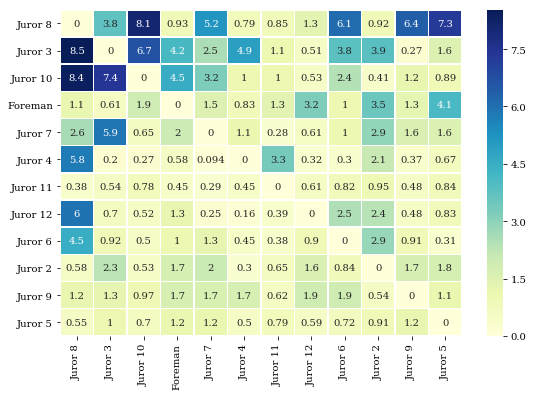

In [219]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

In [220]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


### Barplot of total influences sent/received

In [221]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


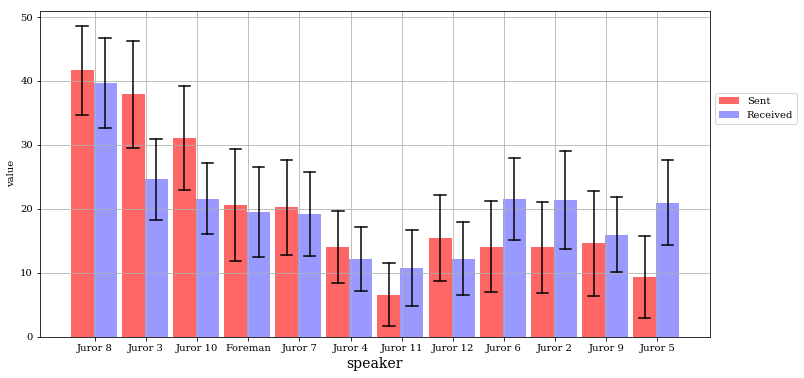

In [222]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [223]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [224]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


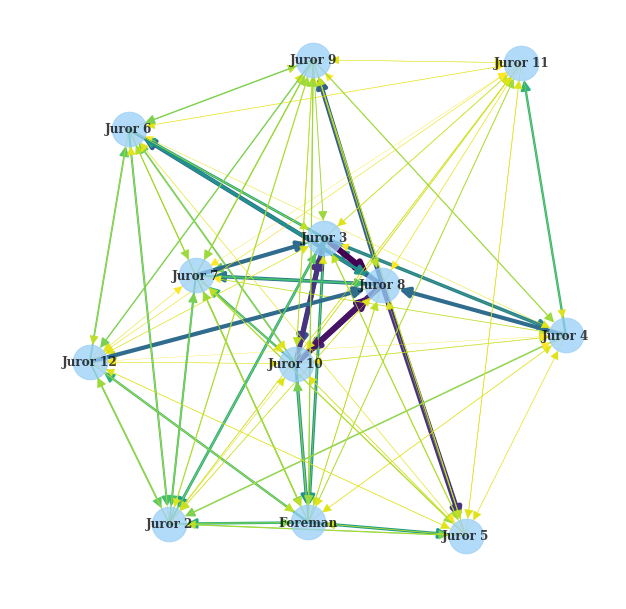

In [225]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


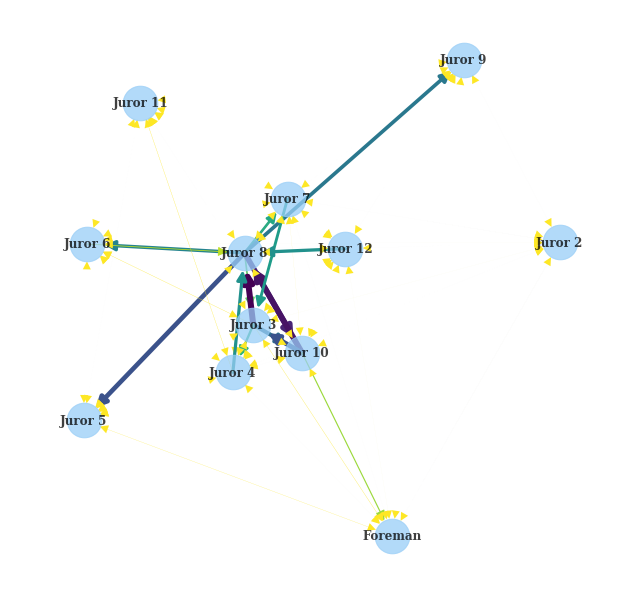

In [226]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


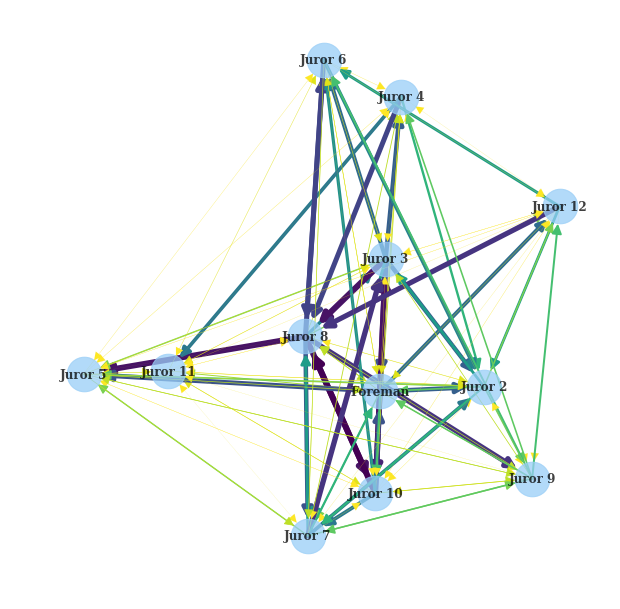

In [227]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [229]:
import lucem_illud
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [230]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

name                                             tokens     start  \
0  Reagan  [hkhb, eaca, djak, hcfh, dfaf, ifdg, bssc, jfl...  0.523706   
1  Carter  [daif, jsek, fgfk, dllb, kaig, sdhb, jjac, hhj...  2.539695   

        end  
0  1.115293  
1  3.928232

Transform data into TalkbankXML format:

In [231]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [233]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

Realtime output can be viewed in shell.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that either (1) take data from a transcribed conversation, online chat forum, comment chain or some other *timed* interaction and calculate Bayesian influence; or (2) build a simulation similar in spirit to the "Presidents" example above, ideally infusing it with interesting "stylized facts". What does that estimation and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

In this part, I will use the transcript of a slice of *Friends* (S1E1) to see the influence network among characters.

### Calculate Bayesian Influence

In [243]:
friends = pandas.read_excel('../data/friendsScript.xlsx', index_col=0)

In [244]:
friends[:2]

name                                          tokens  start  end
0  Monica               [ok, just, breathe, that, is, it]    1.0  1.2
1  Monica  [just, try, to, think, of, nice, calm, things]    1.3  1.6

In [245]:
output_fname = 'friends.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(friends, output_fname, language = language )

New File saved to ./data/friends/friends.xml


0

In [254]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

In [256]:
result_path = '../8-Semantic-Networks/results/friends/'


In [257]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Joey': 2, 'Monica': 0, 'Ross': 1}

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

In [258]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

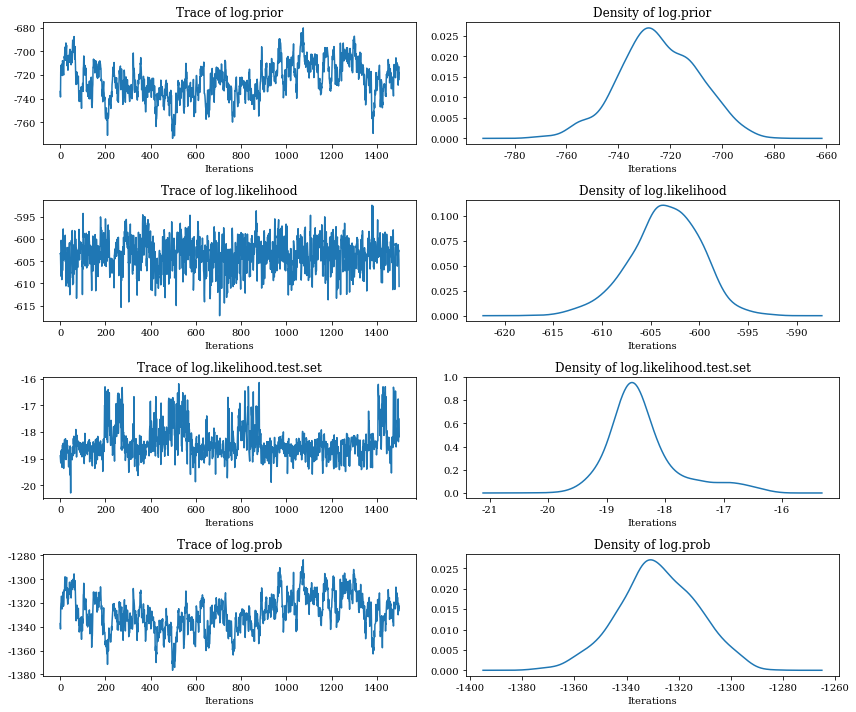

In [259]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [260]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [261]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [262]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [263]:
df_mean

Monica      Ross      Joey
Monica  0.000000  9.013449  9.334295
Ross    6.932656  0.000000  0.958651
Joey    9.356180  8.680441  0.000000

MEAN of influence matrix (row=from, col=to)


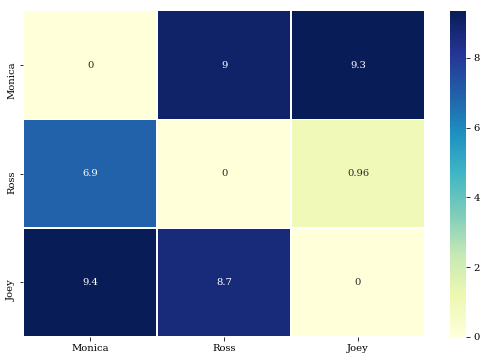

In [264]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

**Based on the heatmap of MEAN of influence matrix, we can see that Monica and Joey have high influence on other characters, while Ross' influence on other people is lower, espcially on Joey.**

SD of influence matrix (row=from, col=to)


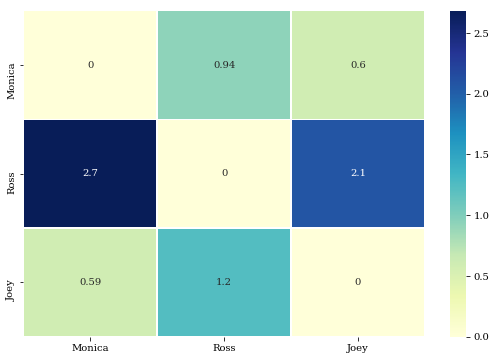

In [265]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

**In contrast to the Mean matrix, the standard deviation of Ross is significantly higher than Monica and Joey.**

### Barplot of total influences sent/received

In [266]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence

		Total linguistic influence sent/received 


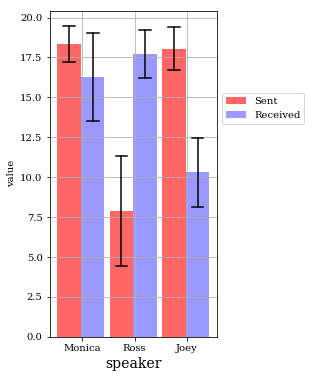

In [267]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

** We can see that Monica sent most information and most of them are received by others. Joey also sent a lot of information, but only half of them has been received. Ross is more like a "receiver", as the value of Ross's received information is highest among three.**

### Visualize Influence Network

In [268]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


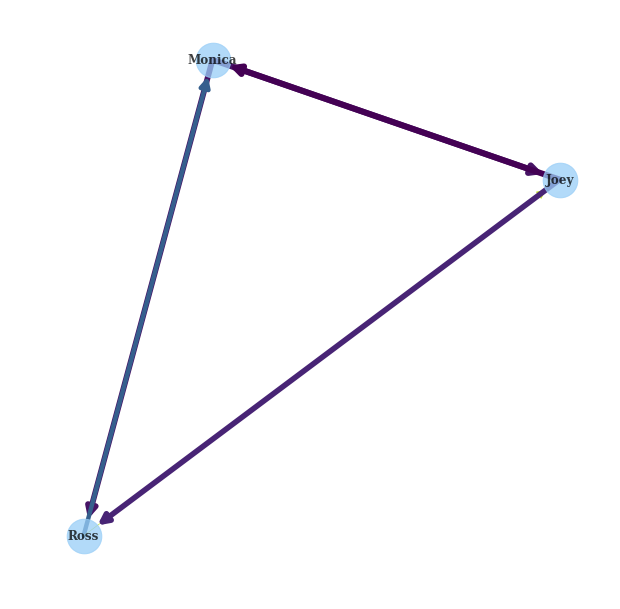

In [269]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

In [270]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

25 Quantile Influence Network


In [271]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

75 Quantile Influence Network


**These three influence network reveal same influence patterns among Ross, Joey and Monica. Monica and Joey both influence Ross, while Ross influences Monica but doesn't influence Joey. At the meanwhile, Monica and Joey can influence each other and their degrees of influence to each other are basically the same.**

## Conclusion

Exploring semantic networks helps us to understanding the social and cultural game underlying Chinese modern poetry of 1920s-1940s, which is a transformation period for both Chinese poetry and Chinese society.

Two main findings in this homework is that:
1) The word "We" (我们）occupies the unbeatable central position in the semantic network, which is consistent with the former literature comments that Chinese poets went through an ideological turn in early 1940s and encouraged to express collectivism in their poems and to connect themselves with the fate of nation.
2) Other nouns that with high centrality in the network like "world" and "soul" are have strong connections with positive symbols (e.g. flame, light) and adjectives (e.g. happy, firm). This reveals Chinese modern poetry's passionate feature that poets held strong wishes about China's lightful and peaceful and therefore reflect this into their writing.

However, since networkx can not read Chinese, and gephi also crashed on my PC, I failed to make a better visualization of the networks.
